# Exploring "The Limitations of Deep Learning in Adversarial Settings"

## Introduction

Adversarial examples in the context of computer vision are images that are crafted with the intent to fool a neural network.  There are many methods for constructing adversarial examples.  Most proceed by taking an image correctly classified by the network and perturbing it in just the right way such that it looks almost identical to the original image yet is misclassified.  Usually, the perturbation is computed using the gradients of the loss function with respect to an input.  In "The limitations of deep learning in adversarial settings," the authors introduce a novel method for computing the perturbations.  They propose using the "forward derivative," which is equivalent to the Jacobian of the neural network with respect to each channel of every pixel of the input image.  Using the Jacobian, they construct an "adversarial saliency map."  Every point in the map corresponds to a channel of a pixel in the input image.  The higher the value the map takes at this point, the more relevant a point is for constructing the adversarial example.  Therefore, the authors propose an algorithm for crafting adversarial examples where the perturbations are made on pixels corresponding to the maximum of the adversarial saliency map.

In the paper, the authors implement their approach on MNIST using the LeNet architecture.  In this report, I implement their technques on CIFAR-10 using the ResNet architecture that I have utilized in previous reports.  I evaluate my results with the same metrics defined in the paper, namely, the success rate, the average distortion, and the adversarial distance.  In addition, I use GradCAMs to visualize how the network reacts to the adversarial examples.

## The Algorithm

A screenshot of Algorithm 1 from the paper is displayed below.  We start with a regular image $\mathbf{X}$ with feature set $\Gamma$ that has been correctly classified by the network.  $\mathbf{F}$ is the neural network.  It takes as input $\mathbf{X}$ and outputs the logit for each class.  The algorithm continues until either the network classifies the adversarial example $\mathbf{X}^{*}$ as the target class or the maximum distortion $\Upsilon$ is reached.  During each iteration of the algorithm, first the forward derivative (Jacobian) is computed.  This jacobian consists of all $\frac{\partial\mathbf{F}_{j}(\mathbf{X})}{\partial\mathbf{X}_{i}}$ where $j$ is a class and $\mathbf{X}_{i}$ is a channel of a pixel.  Looking at these partials as opposed to the partials of the loss is a significant novelty introduced by the paper.  The main attraction of this new approach is that we can now look at gradients specific to a given class.  This allows for a targeted attack, as we can now request the exact output class we wish to see the image classified as.  The adversarial saliency map is computed as in the screenshot given below.  Heuristically, a point $i$ in the map is zero if either $X_{i}$ deters the network from classifying the image as the target class $t$ or $X_{i}$ provokes the network to classify the image to a class other than the target class.  If both these conditions are false, then the value at point $i$ is a function of the Jacobian at $t$ and $i$ and the magnitude of sums of the Jacobian at all other classes and $i$.  Thus, if $i$ is large, then this means that $\mathbf{X}_{i}$ contributes greatly towards provoking the network to classify the image to the target $t$.  So, we proceed by increasing the pixel by $\theta$ in $\mathbf{X}$ that corresponds to the maximum point in the saliency map.  Note that the saliency map is recomputed each iteration with the newly perturbed image.

## Setting the parameters

For this report, each image is 32x32 pixels, and each pixel contains 3 color channels.  So $|\Gamma|=3072$.  This is a noteworthy departure from the paper.  Since the authors were working with MNIST, there was only 1 color channel.  Therefore, the search space of possible pixels/channels to modify is much larger than theirs.  In fact, in the paper, the authors modify Algorithm 1 to Algorithm 2 and 3 in which pairs of pixels are considered in order to increase the search space.  During my experimentation, I did not run into the same problem as the authors.  In addition, when I attempted to implement Algorithm 2 and 3, the search space became so large that the time complexity was too great for the procedure to be practical.  Therefore, I stick to implementing Algorithm 1.  $\mathbf{F}$ in this report is the ResNet I have been using for several reports.  This differs from the authors as they used a network without residual connections.  I don't believe that this difference will have an appreciable effect on the results.  The authors define $\Upsilon$ in terms of the percentage of pixels of the original image that are altered.  Though it is possible for the same pixel in an image to be altered more than once, we can make (as the authors do) the simplifying assumption that the number of pixels altered is equivalent to the number of iterations needed to construct the adversarial image.  The authors consider a distortion rate of 14.5%.  In my implementation, I set the maximum iterations to 150, which is about 14.6% of the total pixels in an image (this is not counting color channels).  Any higher distortion rate results in too long of a computation time.  The increase in pixel channel intensity $\theta$ was set to 1/256 in the paper.  In my experimentation, this low of a value resulted in very slow computations.  Therefore, I use the value 64/256.  I observed that the algorithm has a predilection for selecting some relatively small subset of pixels and increasing them until the maximum intesity for a given color channel is reached.  Thus, using the larger $\theta$ does not seem to drastically alter the adversarial examples as the consequence is just that the maximum intensity for the channel is reached faster.

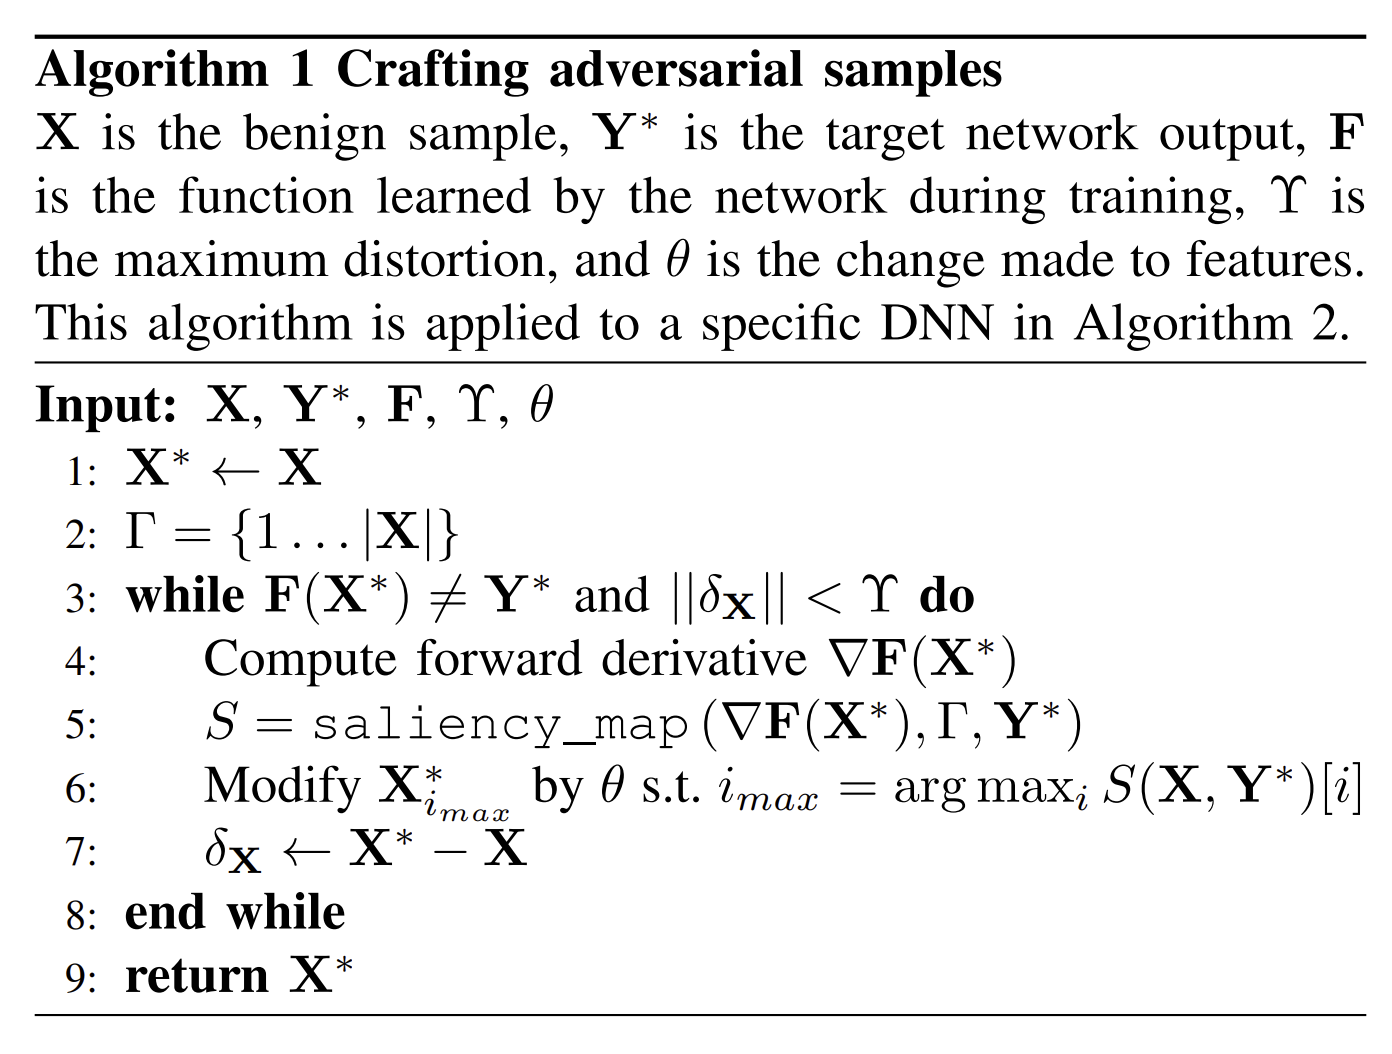

In [353]:
from IPython.display import Image
Image(filename='algorithm1.png', width = 400, height = 200) 

#Algorithm 1 as printed in the paper

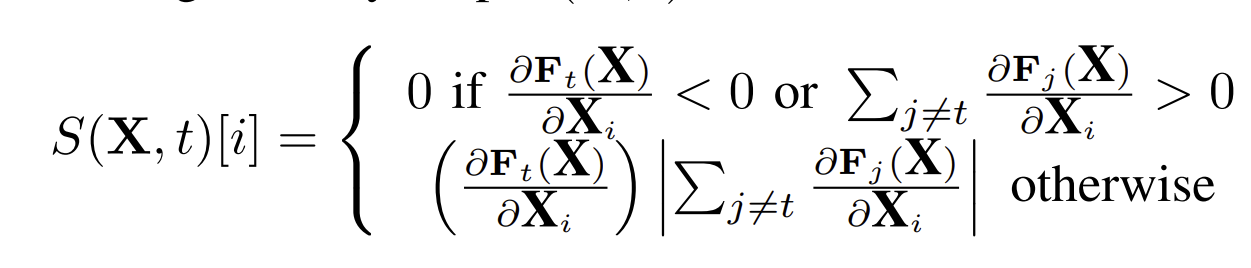

In [354]:
Image(filename='saliencymap.png', width=400, height=200)

#The adversarial saliency map as printed in the paper

## The Network

In [67]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.autograd.functional import jacobian
import torchvision.models as models
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random
import seaborn as sns
import scipy.io
!pip install ttach
!pip install grad-cam
from pytorch_grad_cam import GradCAM
import cv2

In [2]:
#Importing data

train_data, val_data = random_split(datasets.CIFAR10(root='./data', train=True, download=True,
                                                   transform=transforms.ToTensor()), [40000, 10000])
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

labels_dict = {'0': 'airplane',
              '1': 'automobile',
              '2': 'bird',
              '3': 'cat',
              '4': 'deer',
              '5': 'dog',
              '6': 'frog',
              '7': 'horse',
              '8': 'ship',
              '9': 'truck'}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#Setting batch size and constructing dataloaders

batch_size=128

train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, num_workers=4, pin_memory=True)

In [4]:
#Functions for moving tensors/model to GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()

In [5]:
#Functions for training/validating network

class ImageClassificationBase(nn.Module):   
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [6]:
#Functions for computing validation and test accuracy   

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def test_accuracy(model, test_loader):
    corr = 0
    poss = 0
    incorrect = dict()
    confusion_matrix = np.zeros((10,10))
    model.eval()
    for batch in test_loader:
        images, labels = batch
        out = model(images)
        _, preds = torch.max(out, dim=1)
        t = torch.sum(preds == labels).item()
        poss += len(images)
        corr += t
        for y in range(len(preds)):
            if preds[y] != labels[y]:
                if str(labels[y].item()) not in incorrect.keys():
                    incorrect[str(labels[y].item())] = 1
                else:
                    incorrect[str(labels[y].item())] += 1
            confusion_matrix[preds[y].item()][labels[y].item()] += 1
    confusion_matrix = confusion_matrix.astype('int32')
    return corr/poss, incorrect, confusion_matrix

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [7]:
#Residual Block for use in the network

class ResBlock(nn.Module):
    def __init__(self, channels_in, inc, stride):
        super().__init__()
        self.channels_in = channels_in
        self.inc = inc
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(self.channels_in)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv2d(self.channels_in, self.channels_in*self.inc, kernel_size=3, stride=self.stride, padding=1)
        self.bn2 = nn.BatchNorm2d(self.channels_in*inc)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv2d(self.channels_in*inc, self.channels_in*self.inc, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.channels_in, self.channels_in*inc, kernel_size=1, stride=self.stride)
    def forward(self, x):
        residual = x
        if self.stride != 1 or self.inc != 1:
            residual = self.conv3(x)
        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        return out + residual

#The network    

class ResNet(ImageClassificationBase):
    def __init__(self, cbam=False):
        super().__init__()
        self.cbam = cbam
        self.network = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=3, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Conv2d(16,32, kernel_size=3, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          ResBlock(32, 1, 2), #Images reduced to 16x16
          ResBlock(32, 1, 1), 
          ResBlock(32, 1, 1),
          ResBlock(32, 1, 1),
          ResBlock(32, 2, 2), #Images reduced to 8x8
          ResBlock(64, 1, 1), 
          ResBlock(64, 1, 1),
          ResBlock(64, 1, 1),
          ResBlock(64, 2, 2), #Images reduced to 4x4
          ResBlock(128, 1, 1),
          ResBlock(128, 1, 1),
          ResBlock(128, 1, 1),
          ResBlock(128, 2, 1), 
          ResBlock(256, 1, 1),
          ResBlock(256, 1, 1),
          ResBlock(256, 1, 1),
          nn.AvgPool2d(4),
          nn.Flatten(),
          nn.Linear(256,10))
        
    def forward(self, xb):
        return self.network(xb)

In [8]:
#Setting global parameters and loading data

num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [9]:
#Training model

model = ResNet()
to_device(model, torch.device('cuda'))
results = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8081, val_loss: 1.4061, val_acc: 0.5008
Epoch [1], train_loss: 1.1908, val_loss: 1.4475, val_acc: 0.5220
Epoch [2], train_loss: 0.9320, val_loss: 1.5121, val_acc: 0.5632
Epoch [3], train_loss: 0.7678, val_loss: 0.8425, val_acc: 0.7080
Epoch [4], train_loss: 0.6437, val_loss: 0.8028, val_acc: 0.7294
Epoch [5], train_loss: 0.5629, val_loss: 0.7490, val_acc: 0.7501
Epoch [6], train_loss: 0.4693, val_loss: 0.6502, val_acc: 0.7808
Epoch [7], train_loss: 0.3952, val_loss: 0.6418, val_acc: 0.7888
Epoch [8], train_loss: 0.3273, val_loss: 0.8828, val_acc: 0.7522
Epoch [9], train_loss: 0.2648, val_loss: 0.7873, val_acc: 0.7825
Epoch [10], train_loss: 0.2154, val_loss: 0.8516, val_acc: 0.7786
Epoch [11], train_loss: 0.1791, val_loss: 0.9725, val_acc: 0.7571
Epoch [12], train_loss: 0.1647, val_loss: 0.8799, val_acc: 0.7796
Epoch [13], train_loss: 0.1255, val_loss: 1.0440, val_acc: 0.7729
Epoch [14], train_loss: 0.1112, val_loss: 1.0530, val_acc: 0.7811
Epoch [15], train_lo

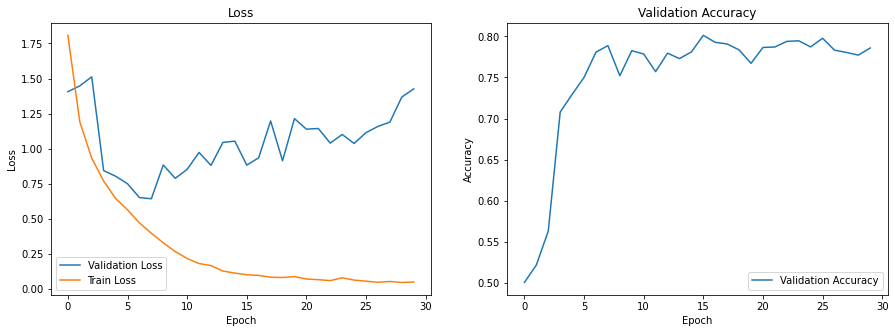

In [194]:
#Plotting results

results_df = pd.DataFrame(results)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(range(30), results_df['val_loss'], label="Validation Loss")
axs[0].plot(results_df['train_loss'], label="Train Loss")
axs[0].set_title('Loss')
axs[0].legend(loc='lower left')
axs[0].set(xlabel='Epoch', ylabel='Loss')
axs[1].plot(range(30), results_df['val_acc'], label="Validation Accuracy")
axs[1].set_title('Validation Accuracy')
axs[1].legend(loc='lower right')
axs[1].set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

The losses and validation accuracy are plotted above.  They exhibit the same properties as observed in previous reports.

In [111]:
accuracy, incorrect_dict, confusion_matrix = test_accuracy(model, test_dl)

In [355]:
print('The testing accuracy of the network is', accuracy)

The testing accuracy of the network is 0.7765


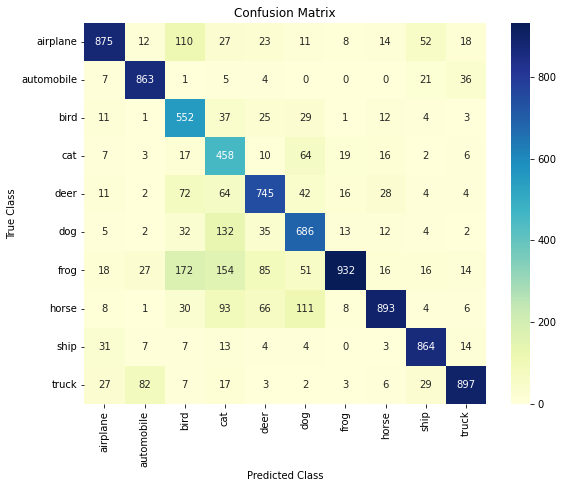

In [195]:
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in labels_dict.values()],
                  columns = [i for i in labels_dict.values()])
plt.figure(figsize = (9,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='d').set(title='Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

Above, the confusion matrix for the network is displayed.  I will be using this matrix as a guide below for exploring the results of the adversarial example crafting algorithm.  Some observations that will be of use include the fact that there seems to be a lot of confusion between the animal classes and little confusion outside of these classes.  Note as well that there is very low accuracy for the cat class.

## Implementing the Algorithm

Below begins the implementation of the algorithm.  I start with collecting 20 test images per class that were correctly classified by the network.  The authors were able to use thousands of examples per class, but I found that 20 per class was about all that I had time for, as the total time to craft the images was about 15 hours.

In [16]:
#Collecting the images

test_images = {'0': [],
               '1': [],
               '2': [],
               '3': [],
               '4': [],
               '5': [],
               '6': [],
               '7': [],
               '8': [],
               '9': []}

for batch in test_dl:
    images, labels = batch
    out = model(images)
    predictions = torch.argmax(out, dim=1)
    for i in range(predictions.size()[0]):
        if predictions[i] == labels[i] and len(test_images[str(labels[i].item())]) < 20:
            test_images[str(predictions[i].item())].append(images[i].unsqueeze(0))



In [198]:
#Functions for constructing the adversarial saliency map

def get_jacobian(model, images):
    jac = jacobian(model, images)
    indv_jacs = [jac[t,:,t,:].unsqueeze(0) for t in range(jac.size()[0])]
    jac_red = torch.cat(indv_jacs, 0)
    return jac_red

def get_advers_sal_map(images, target, model):
    jac = get_jacobian(model, images)
    sal_map = torch.zeros((images.size()[0],3,32,32))
    for i in range(3):
        for j in range(32):
            for k in range(32):
                jit = jac[:,target,i,j,k]
                other_sum = 0
                for t in range(0,10):
                    if t != target:
                        other_sum += jac[:,t,i,j,k]
                for r in range(images.size()[0]):
                    if jit[r] > 0 and other_sum[r] < 0: 
                        sal_map[r,i,j,k] = jit[r]*torch.abs(other_sum[r])
    return sal_map

### Visualizing Adversarial Saliency Maps

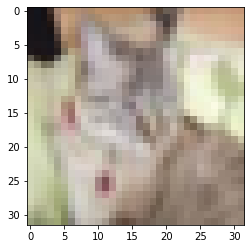

In [281]:
plt.imshow(test_images['3'][1].squeeze().cpu().permute(1,2,0))

Above is a sample image that will be used to visualize some adversarial saliency maps.  I will be looking at the map generated for targeting each of the 10 classes.  The authors opted to plot these maps as surface plots. However, since the channels are relevant for this report, I will be visualizing these maps as images.  Since points in the map can take non-negative values greater than 1, I use min/max scaling to make the maps valid images.

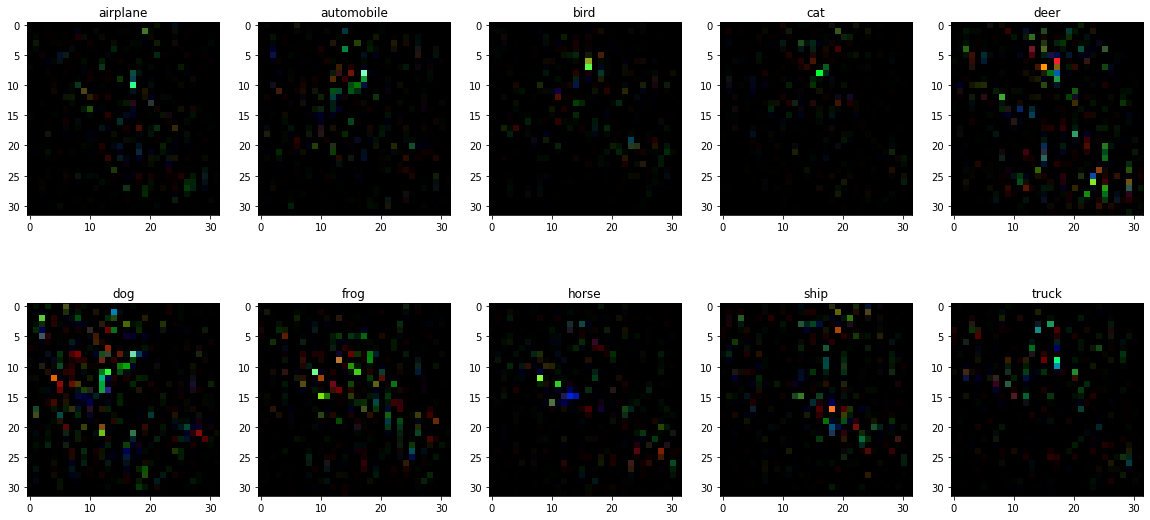

In [284]:
#Computing and plotting example adversarial saliency maps

example_advers_sal_map = []

for i in range(10):
    ad_map = get_advers_sal_map(test_images['3'][1], i, model)
    maxim = torch.max(ad_map).item()
    minim = torch.min(ad_map).item()
    ad_map = (ad_map - minim) / (maxim-minim)
    example_advers_sal_map.append(ad_map)

df_ex = pd.DataFrame (example_advers_sal_map, columns = ['Example Maps'])

titles = list(labels_dict.values())
fig = plt.figure(figsize=(20, 25))
counter = 1
for i in range(10):
    a = fig.add_subplot(5, 5, counter)
    counter += 1
    imgplot = plt.imshow(df_ex["Example Maps"][i].squeeze().cpu().permute(1,2,0))
    a.set_title(titles[i])
    


Above are the example adversarial saliency maps for the cat example.  First, note that the map for the cat class is almost completely zero.  This makes sense, as the image has been classified already as a cat, so we would expect the gradients of each pixel to be small.  Also, the animal classes seems to be the most dramatic.  For each of these classes, there are many points with high gradients.  Therefore, the network should have an easier time crafting the adversarial images for these classes (for the example image above).  This comports with the confusion matrix, which showed the network's tendency to misclassify animals.  This contrasts with the non-animal classes which are not as dramatic.  Thus, I expect it to be more difficult to craft adversarial images for these classes.

### Computing the Adversarial Distances

In the paper, the authors looked at a measure they describe as the adversarial distance.  This metric is computed for every possible source-target pair.  It is defined as 1 minus the number of points greater than zero in the initial adversarial saliency map (before any perturbations), averaged over every test image for the source-target pair (see equation 13 of paper).

In [359]:
Functions for computing the adversarial distances

def get_advers_distance(images, target, model):
    advers_map = get_advers_sal_map(images, target, model)
    greater_than_zero = torch.count_nonzero(advers_map)
    advers_distance = 1 - greater_than_zero / (3*32*32*images.size()[0])
    return advers_distance

def get_advers_distance_matrix(images_dict, model):
    advers_distance_matrix = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            images = images_dict[str(i)]
            advers_distance = get_advers_distance(torch.cat(images), j, model)
            advers_distance_matrix[i,j] = advers_distance
    return advers_distance_matrix

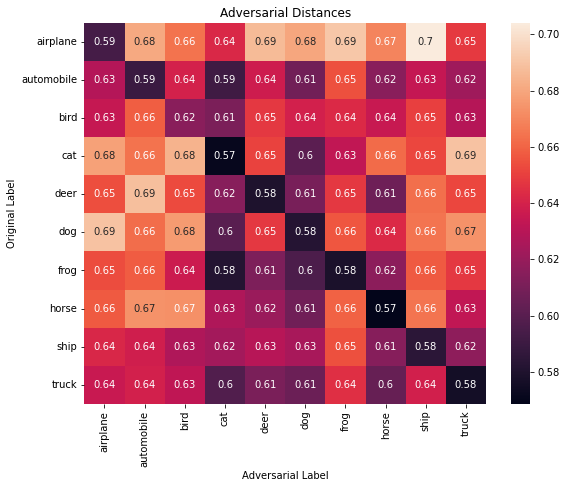

In [238]:
#Plotting the adversarial distances

advers_dist_mat = get_advers_distance_matrix(test_images, model)
df_advers_htmap = pd.DataFrame(advers_dist_mat, index = [i for i in labels_dict.values()],
                  columns = [i for i in labels_dict.values()])
plt.figure(figsize = (9,7))
sns.heatmap(df_advers_htmap, annot=True).set(title='Adversarial Distances')
plt.xlabel('Adversarial Label')
plt.ylabel('Original Label')
plt.show()

Above is the table containing the adversarial distances.  A high adversarial distance means that it should be difficult to transform the source to the target.  It is noteworthy that the table looks similar to the confusion matrix (as the authors find in their case as well).  For example, the network misclassified many frogs as cats, and the adversarial distance between frogs and cats is very low (0.58).  The distances seem to be small for the animals and large in the other source-target pairs, which is what we observed in the confusion matrix.

### Coding up the algorithm

In [182]:
def get_max_indices(tensor):
    """
    Gets the top 50 elements of a tensor (the top
    50 are needed in case a pixel channel goes to 1
    and can no longer be used by the algo.)
    """
    indices = []
    for t in range(tensor.size()[0]):
        top_k_indices = []
        flat = torch.flatten(tensor[t])
        top_k = torch.topk(flat, 50)[1]
        array = tensor[t].cpu().numpy()
        for i in range(50):
            top_k_indices.append(np.unravel_index(top_k[i].item(), (3,32,32)))
        indices.append(top_k_indices)
    return indices

def update_remaining_images_labels(remaining_labels, remaining_images, target):
    """
    Removes images in batch that are completed
    """
    to_keep = []
    finished = []
    adv_images = []
    continue_along = True
    for l in range(remaining_labels.size()[0]):
        if remaining_labels[l] != target:
            to_keep.append(l)
        else:
            finished.append(l)
    adv_images += [remaining_images[k,:].unsqueeze(0) for k in finished]
    if to_keep != []:
        images_to_keep = [remaining_images[k,:].unsqueeze(0) for k in to_keep]
        labels_to_keep = [remaining_labels[k].unsqueeze(0) for k in to_keep]
        remaining_images = torch.cat(images_to_keep)
        remaining_labels = torch.cat(labels_to_keep)
    else:
        continue_along = False
    return to_keep, finished, adv_images, continue_along, remaining_images, remaining_labels

def get_finished_org_indices(finished, remaining_indices):
    """
    Gets the original indices of completed images
    in the batch and removes them from the algorithm
    """
    org_ind = []
    for i in range(len(finished)):
        org_ind.append(remaining_indices[finished[i]-i])
        remaining_indices.pop(finished[i]-i)
    return org_ind

def update_df(org_ind, df, iters, org_images, adv_images, target, org_label, success, remaining_indices):
    """
    updates dataframe storing results after image complete
    or max iters reached
    """
    if success == True:
        for i in range(len(org_ind)):
            new_row = {"Original Label": org_label, 
                "Target": target, 
                "Original Image": org_images[org_ind[i]].cpu(), 
                "Adversarial Image": adv_images[i].cpu(), 
                "Iterations": iters,
                "Success": success}
            df = df.append(new_row, ignore_index=True)
    if success == False:
        for i in remaining_indices:
            new_row = {"Original Label": org_label, 
                "Target": target, 
                "Original Image": org_images[i].cpu(), 
                "Adversarial Image": 0, 
                "Iterations": iters,
                "Success": success}
            df = df.append(new_row, ignore_index=True)
    return df

def get_advers_images(images, target, model, theta, org_label):
    """
    Crafts the adversarial images for a batch of images
    """
    #Store remaining images/labels/indices.  Updated during algo
    
    remaining_labels = torch.argmax(model(images), dim=1)
    remaining_images = images.detach().clone()
    remaining_indices = list(range(images.size()[0]))
    df = pd.DataFrame({})
    continue_along = True
    iters = 0
    
    #Begin crafting images
    
    while continue_along == True and iter<500:
        print('Numb Iters:', iter, 'Remaining Imgs:', len(remaining_labels))
        
        #Get maps and max indices of map
        
        sal_map = get_advers_sal_map(remaining_images, target, model)
        max_indices = get_max_indices(sal_map)
        
        #Update relevant pixels
        
        for i in range(len(max_indices)):
            for t in range(50):
                if remaining_images[i, max_indices[i][t][0], max_indices[i][t][1], max_indices[i][t][2]] + theta < 1:
                    remaining_images[i, max_indices[i][t][0], max_indices[i][t][1], max_indices[i][t][2]] += theta
                      break
                else:
                    remaining_images[i, max_indices[i][t][0], max_indices[i][t][1], max_indices[i][t][2]] = 1
        
        #Update labels/images/indices
        
        remaining_labels = torch.argmax(model(remaining_images), dim=1)
        to_keep, finished, adv_images, continue_along, remaining_images, remaining_labels = \
        update_remaining_images_labels(remaining_labels, remaining_images, target)
        finished_org_indices = get_finished_org_indices(finished, remaining_indices)
        
        iters += 1
        
        #Update datafram
    
        if len(finished) != 0:
            df = update_df(finished_org_indices, df, iters, images, adv_images, target, org_label, True, remaining_indices)
    
    #Add failed results to datafram
    
    if len(remaining_indices) != 0:
        df = update_df(finished_org_indices, df, iters, images, adv_images, target, org_label, False, remaining_indices)
        
    return df

def run_images(images, org_label, model, file_name):
    """
    Function for running batch of images
    """
    df = None
    counter = 0
    for i in range(10):
        if i != org_label:
            print('Running org label', org_label, 'to target label', i)
            dfi = get_advers_images(images, i, model, 64/256, org_label)
        if counter != 0:
            df = pd.concat([df,dfi], ignore_index=True)
        else:
            df = dfi
        counter += 1
        name = str(i)+file_name
        df.to_pickle(name)
    return df

### Experiment with empty input

The authors try an interesting experiment with their algorithm.  They see what adversarial images are created by inputing a blank image into the algorithm.  I attempt this on my implementation as well.

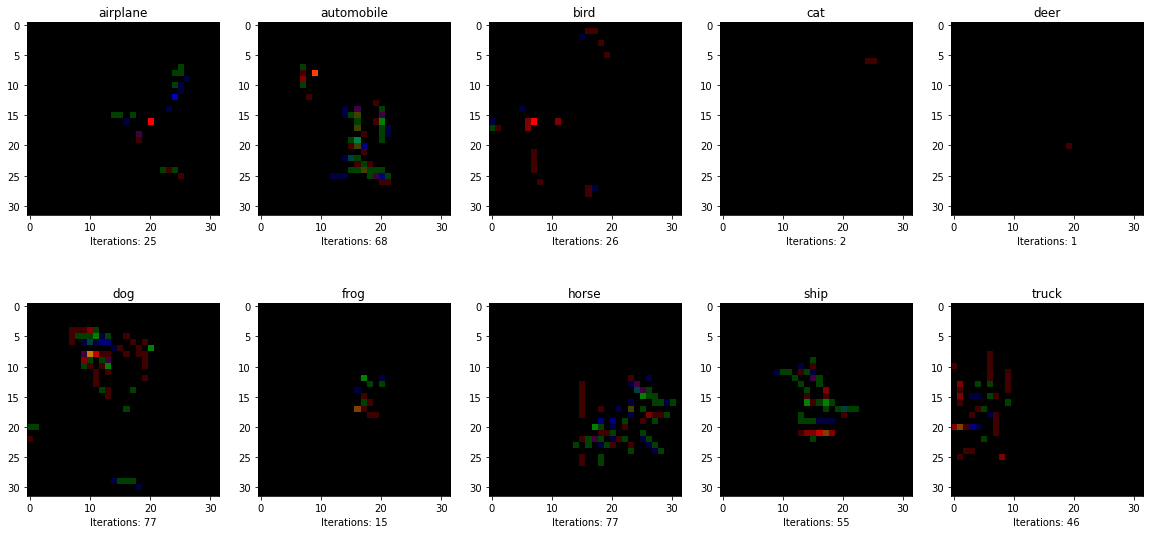

In [263]:
#Getting blank images and running them on algo

blank = torch.zeros((1,3,32,32)).cuda()
df_blanks = None
for i in range(10):
    adv_img = get_advers_images(blank, i, model, 64/256, 'NoLabel')
    if i==0:
        df_blanks = adv_img
    else:
        df_blanks = pd.concat([df_blanks, adv_img], ignore_index=True)
        
#Plotting results

xlabels = ["Iterations: " + str(int(df_blanks["Iterations"][i])) for i in range(10)]
titles = list(labels_dict.values())
fig = plt.figure(figsize=(20, 25))
counter = 1
for i in range(10):
    a = fig.add_subplot(5, 5, counter)
    counter += 1
    imgplot = plt.imshow(df_blanks["Adversarial Image"][i].squeeze().cpu().permute(1,2,0))
    a.set_xlabel(xlabels[i])
    a.set_title(titles[i])



Above are the results of the experiment of running blank images through the algorithm.  The authors were able to get more interesting results than I was.  For example the adversarial image for a 0,2,3 and 5 looked very much like correct digits.  It is understandable that this didn't happen in my case.  The CIFAR-10 data is more complex than MNIST.  Intuitively, this is because there are many different depictions of cats, planes, ships, etc., while numerals from the same class are fairly similar compared to the CIFAR-10 data.  That being said, there are some interesting results from this experiment.  The animal classes are very dark with few pixels modified which comports with the observations made above.  A notable exception is the dog case which required 77 iterations.  Also, if you squint, maybe the image created for the airplane class looks a little like a plane.  The fact that the cat and deer classes took very few iterations is an indication that the network has a bias for these classes as a nearly blank image gets identified with these classes.

### Running the algorithm on the test images

In [360]:
#Running the images and storing as dataframes

df_zero = run_images(torch.cat(test_images['0']), 0, model, 'zero.pkl')
df_one = run_images(torch.cat(test_images['1']), 1, model, 'one.pkl')
df_two = run_images(torch.cat(test_images['2']), 2, model, 'two.pkl')
df_three = run_images(torch.cat(test_images['3']), 3, model, 'three.pkl')
df_four = run_images(torch.cat(test_images['4']), 4, model, 'four.pkl')
df_five = run_images(torch.cat(test_images['5']), 5, model, 'five.pkl')
df_six = run_images(torch.cat(test_images['6']), 6, model, 'six.pkl')
df_seven = run_images(torch.cat(test_images['7']), 7, model, 'seven.pkl')
df_eight = run_images(torch.cat(test_images['8']), 8, model, 'eight.pkl')
df_nine = run_images(torch.cat(test_images['9']), 9, model, 'nine.pkl')

In [205]:
#Concatenating dataframes

df_adv_images = pd.concat([df_zero,df_one,df_two,df_three,df_four,df_five,df_six,df_seven,df_eight,df_nine], ignore_index=True)

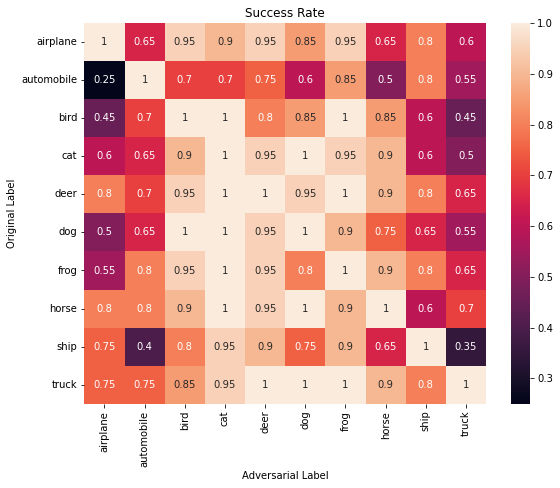

In [280]:
#Computing and plotting success rates

success_matrix = np.zeros((10,10))
for i in range(10):
    success_matrix[i,i] = 1
for i in range(len(df_adv_images["Original Label"])):
    if df_adv_images["Success"][i] == 1.0:
        success_matrix[int(df_adv_images["Target"][i]), int(df_adv_images["Original Label"][i])] += 1/20
        
df_success_rate = pd.DataFrame(success_matrix, index = [i for i in labels_dict.values()],
                  columns = [i for i in labels_dict.values()])
plt.figure(figsize = (9,7))
sns.heatmap(df_success_rate, annot=True).set(title='Success Rate')
plt.xlabel('Adversarial Label')
plt.ylabel('Original Label')
plt.show()

The success rates for each source-target pair are above (A rate of 1 was imputed for the diagonal classes).  As expected, we see very high success rates for the animal classes and lower rates for the other classes.  In particular, the algorithm successfully created adversarial images for each animal-cat pair.  The network's bias for classifying things as cats is probably responsible for this.  Of note, only 5 automobiles were successfully converted to airplanes.  In addition, the algorithm poorly converted images to the truck class.  I have noticed working with this dataset that the trucks tend to take up more space in the image compared to the other classes.  Maybe there are just too many pixels that need to be modified in order to convert an image to a truck.

### Computing the average required distortion

The authors define a metric they call the average distortion.  This is defined as the fraction of pixels that must be modified to successfully convert the source to the target averaged over all test images in the source-target pair.  Since in my case, one pixel is modified per iteration, I simply look at the number of iterations.

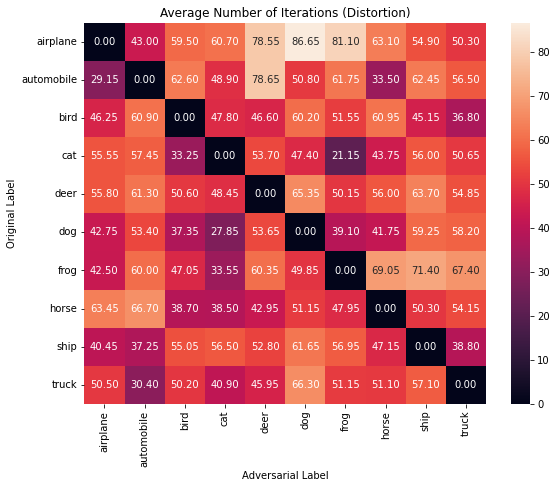

In [357]:
#Computing distortion

distortion_matrix = np.zeros((10,10))

for i in range(len(df_adv_images["Original Label"])):
    if df_adv_images["Success"][i] == 1.0:
        iterations = df_adv_images["Iterations"][i]
        distortion_matrix[int(df_adv_images["Target"][i]), int(df_adv_images["Original Label"][i])] += iterations/20
        
#Plotting results
        
df_distortion = pd.DataFrame(distortion_matrix, index = [i for i in labels_dict.values()],
                  columns = [i for i in labels_dict.values()])
plt.figure(figsize = (9,7))
sns.heatmap(df_distortion, annot=True, fmt='.2f').set(title='Average Number of Iterations (Distortion)')
plt.xlabel('Adversarial Label')
plt.ylabel('Original Label')
plt.show()

The distortion for each source-target pair are above.  As expected, the frog-cat and cat-frog pair required very vew iterations, as did many of the animal pairings.  A noteable exception is the dog-deer pair.  The airplane images performed very poorly.  A surprising result is that it took only 29.15 iterations on average to convert an automobile to a plane.  Recall that the number of successes for this pair was just 5.  Apparently those 5, unlike the others in their class, were very easy to convert.

### GradCAM analysis

Going beyond what was done in the paper, I thought it would be interesting to compute the GradCAMs for a selection of original images and a some of their adversarial images.

In [313]:
#Get GradCAMs function

def get_heatmap(img, layer, model):
    cam = GradCAM(model, layer, use_cuda=True)
    grayscale_cam = cam(input_tensor=img)
    grayscale_cam = grayscale_cam[0,:]
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    timg = img[0].cpu().permute(1,2,0).numpy()
    out = 1*heatmap + timg
    out = out / np.max(out)
    out = np.uint8(255 * out)
    return out

#function for creating figures for comparison below

def create_figure(df, df_index, layer, model):
    org_img = df["Original Image"][df_index].unsqueeze(0)
    advers_img = df["Adversarial Image"][df_index]
    org_heatmap = get_heatmap(org_img, layer, model)
    advers_heatmap = get_heatmap(advers_img, layer, model)
    fig = plt.figure(figsize=(20, 25))
    a = fig.add_subplot(5, 5, 1)
    imgplot1 = plt.imshow(org_heatmap)
    a.set_title("Original GradCAM")
    b = fig.add_subplot(5, 5, 2)
    imgplot1 = plt.imshow(org_img.squeeze().cpu().permute(1,2,0))
    b.set_title("Original Image")
    org_label = labels_dict[str(int(df["Original Label"][df_index]))]
    b.set_xlabel("Original Label: " + org_label)
    c = fig.add_subplot(5, 5, 3)
    imgplot1 = plt.imshow(advers_img.squeeze().cpu().permute(1,2,0))
    c.set_title("Adversarial Image")
    advers_label = labels_dict[str(int(df["Target"][df_index]))]
    c.set_xlabel("Adversarial Label: " + advers_label)
    d = fig.add_subplot(5, 5, 4)
    imgplot1 = plt.imshow(advers_heatmap)
    d.set_title("Adversarial GradCAM")

Recall the strange relationship between the automobile and airplane classes.  Below is the test image of an automobile that was converted in the maximum number of iterations of the source-target pair.  While the image has been fairly distorted (though clearly recognizable as a car), the GradCAM is completely unchanged.

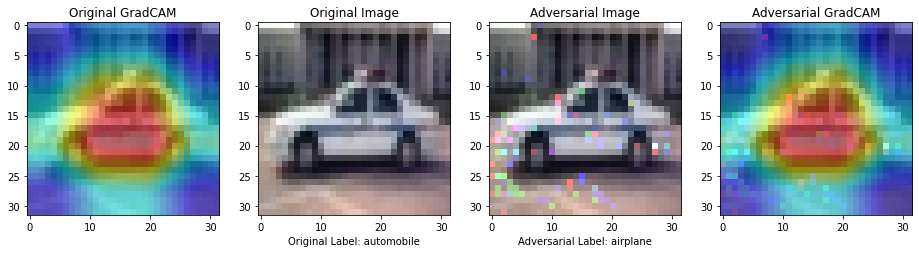

In [321]:
create_figure(df_adv_images, 192, model.network[21].conv2, model)

There was a low success rate for the ship-truck pair, so I thought it would be good to look at an example.  This ship required the maximum number of iterations for the pair.  The distortion is not that noticeable compared to some of the others as the distortion blends in with the color of the water.  The GradCAMs are again very similar, but the adversarial image seems to have a bit more focus in its GradCAM.

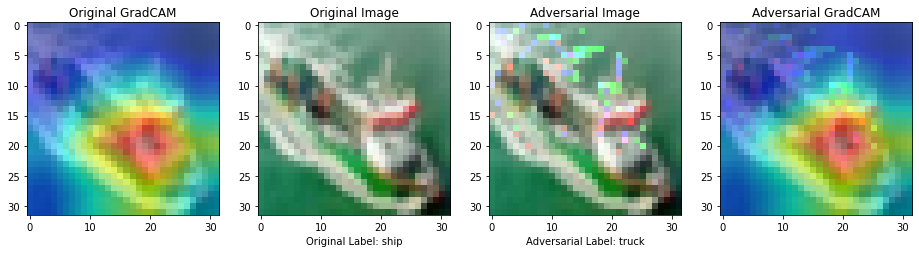

In [326]:
create_figure(df_adv_images, 1615, model.network[21].conv2, model)

Here is an example of a dog-cat pairing.  This dog required the minimal number of iterations to convert in its class.  There are just a few noticable pixels in the center of the adversarial image that have been changed.  It is not surprising then that the GradCAMs are nearly identical.

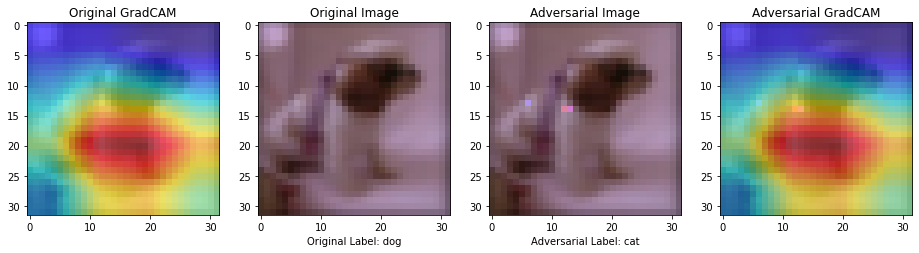

In [329]:
create_figure(df_adv_images, 960, model.network[21].conv2, model)

This dog required an average number of iterations to convert in its pair class.  The changes are pretty noticable against the brown fur of the dog.  The GradCAMs in this case are very different compared to the other examples.  In the original case, the GradCAM completely captures the dog, while in the adversarial case this is not so.

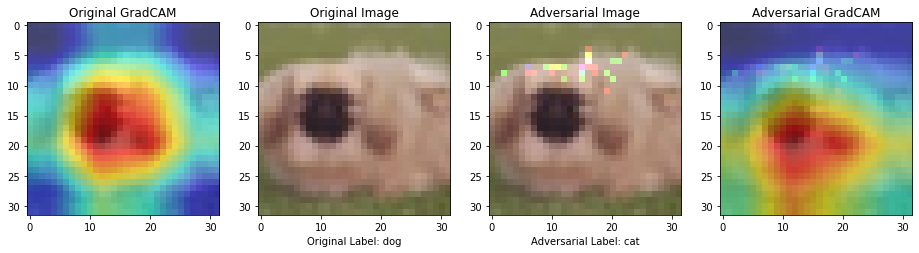

In [332]:
create_figure(df_adv_images, 966, model.network[21].conv2, model)

Here is a case of a deer-car pair that required the maximum number of iterations in the class.  It is interesting to see that most of the distortion is in the bush and not on the deer itself.  The GradCAMs again look very similar.

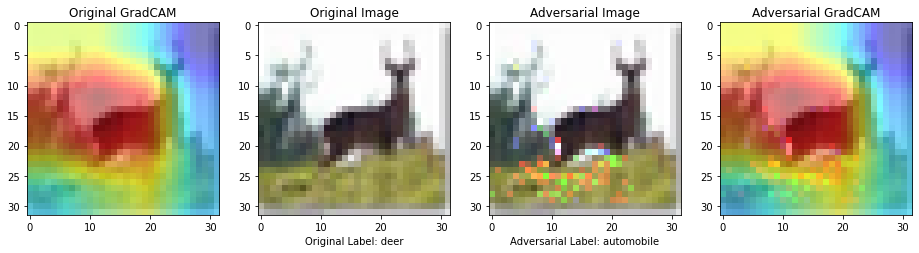

In [336]:
create_figure(df_adv_images, 753, model.network[21].conv2, model) 

# Conclusions

The algorithm seems to have performed pretty well with the CIFAR-10 data.  The paper achieved a much better success rate, but this may because they implemented the pixel-pair version of the algorithm.  This increases the search space and allows for selecting pairs of pixels more relevant to the crafting algorithm.  If I had more time and resources, I would have liked to try this version of the algorithm.  We saw how the adversarial distance provided a fairly valid metric for predicting the difficulty in crafting the image.  After looking at a few example results, we saw that the distortion was barely apparent in some images but very noticable in others.  In addition, after looking at a few examples, I suspect that the adversarial images have little impact on GradCAMS, suggesting that the adversaries fool the network by other means than simply distracting the attention of the network  Overall, the methods implemented in this report are worth considering for crafting adversarial examples, especially since they allow for a targeted approach.